In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
import time, traceback 
from sklearn.metrics import roc_auc_score
from skimage.metrics import structural_similarity as compare_ssim
warnings.filterwarnings('ignore')

## Evaluation Methods / cost function

In [15]:
"""definition of cost function """
def compute_performance_metric(edge_image, ground_truth, f, ksize, m):
    # F1, AUC, ESSIM, continuity (엣지 연결성)
    f1, auc = calculate_metrics(edge_image,ground_truth)
    essim = compute_essim(edge_image, ground_truth, f, ksize, m)
    continuity = compute_continuity(edge_image)
    computing_cost = 1 # memory, processing time 
    return f1 * 0.3 + essim * 0.3 + continuity * 0.3 + computing_cost * 0.1

"""compute f1-score and AUC score"""
def calculate_metrics(gt, edge_detected):
    TP = np.sum((gt == 255) & (edge_detected == 255))
    FP = np.sum((gt == 0) & (edge_detected == 255))
    FN = np.sum((gt == 255) & (edge_detected == 0))
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # harmonic mean of recall and precision 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
    # auc score 
    gt_binary = ((gt == 255).flatten()).astype(int)
    edge_detected_binary = ((edge_detected == 255).flatten()).astype(int)
    try : 
        auc_score = roc_auc_score(gt_binary, edge_detected_binary)
    except : 
        auc_score = 0.5
    return f1_score, auc_score


"""compute essim"""
def compute_essim(img1, img2, f, ksize, m):
    luminance1, luminance2 = compute_luminance(img1, img2)
    contrast1, contrast2 = compute_contrast(img1, img2)
    edges1, edges2 = edge_detection(img1, f, ksize, m), edge_detection(img2, f, ksize, m)

    l = (2 * luminance1 * luminance2 + 0.01) / (luminance1**2 + luminance2**2 + 0.01)
    c = (2 * contrast1 * contrast2 + 0.03) / (contrast1**2 + contrast2**2 + 0.03)
    e = compare_ssim(edges1, edges2)

    return l * 0.33 + c * 0.33 + e * 0.33

"""compute luminance of two images"""
def compute_luminance(img1, img2):
    return np.mean(img1), np.mean(img2)

"""compute contrast of two images"""
def compute_contrast(img1, img2):
    return np.std(img1), np.std(img2)


"""compute continuity"""
def compute_continuity(edge_image) : 
    edge_seg, edgels = find_edges_and_segments(edge_image)
    epsilon = 1e-10
    continuity = len(edgels) / (len(edge_seg) + epsilon)
    return continuity
    
def find_edges_and_segments(binary_image, threshold=15):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    edge_segments = contours  
    
    edge_lines = []
    for contour in contours:
        if len(contour) > threshold :  
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            edge_lines.append(approx)
    
    return edge_segments, edge_lines

## Best Edge detector, parameter searching function

In [16]:
"""edge detecting with best params"""
def run_best_edge_detector(image, **params) :
    if params :
        ksize = params['kernel_size']
        ftype = params['filter_type']
        auto_method = params['auto_method']
        if ftype == 'gauss' :
            blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
        elif ftype == 'median' : 
            blur = cv2.medianBlur(image, ksize)
        else :
            blur = image.copy()
        
        if auto_method == 'median' : 
            edge = auto_canny(blur)
        else :
            edge = auto_canny_otsu(blur)
    else :
        edge = canny(image)
    return edge


"""search best parameters with Grid search"""
def searching_best_params(first_frame) :
    filter_type = ['gauss', 'median', ] # 'guided']
    auto_method = ['median','otsu']
    kernel_sizes=[5,7,9]

    best_score = 0
    best_params = {}

    gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    for f, ksize, m in product(filter_type, kernel_sizes, auto_method) :
        rand_scores = 0  
        for i in range(10) :
            GT = edge_detection(gray, f, ksize, m)

            rand_img  =  transform_img(gray, seed=i)
            rand_edge = edge_detection(rand_img, f, ksize, m)
            rand_scores += compute_performance_metric(rand_edge, GT, f, ksize, m)

        rand_scores = rand_scores / 10 

        if rand_scores > best_score:
            best_score = rand_scores
            best_params = {"kernel_size" : ksize, "filter_type" : f,
                          'auto_method' : m}
    print('=' * 25)
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params

In [17]:
"""edge simplifier"""
def simplify_edges(edge) : 
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    count_threshold = np.percentile([len(c) for c in contours], 50)
    length_threshold = np.percentile([cv2.arcLength(c, True) for c in contours], 50)
    contour_list = [c for c in contours if len(c) > count_threshold and cv2.arcLength(c, True) > length_threshold]         
    binary_contour_image = np.zeros(edge.shape, dtype=np.uint8)
    cv2.drawContours(binary_contour_image, contour_list, -1, (255, 255, 255), 1)
    return binary_contour_image

"""Edge Detecting Method (Canny thresholding)"""
def auto_canny(img, sigma=0.33) : 
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = np.median(img)
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
    return cv2.Canny(img, lower, upper)

def auto_canny_otsu(image):
    if len(image.shape) == 3 :
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    return cv2.Canny(image, low_thresh, high_thresh)

def canny(img) : 
    if len(img.shape) == 3 :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(img, 100, 200)

In [18]:
"""random transformation with brightness, contrast"""
def transform_img(img, seed) : 
    v = np.arange(0.2, 2.1, 0.1)
    np.random.seed(seed)
    factor1 = np.random.choice(v)
    np.random.seed(seed+1)
    factor2 = np.random.choice(v)
    
    img = np.array(255 * (img / 255) ** factor1, dtype='uint8')
    return  cv2.multiply(img, factor2)

"""edge detection with certain params"""
def edge_detection(image, filter_type, kernel_size, auto_method):
    if len(image.shape) == 3 :
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else :
        gray = image.copy()
    if filter_type == 'gauss' : 
        blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    elif filter_type == 'guided' :
        blur = cv2.ximgproc.guidedFilter(guide=gray.copy(), src=gray, radius=kernel_size, eps=eps)
    else : 
        blur = cv2.medianBlur(gray, kernel_size)
        
    if auto_method == 'median' :
        edge = auto_canny(blur)
    else : 
        edge = auto_canny_otsu(blur)
        
    return edge

## Finding Feature points 

In [76]:
"""return new points, lines, edge image (simplified)"""
def find_new_points(frame, hough_threshold, min_line_length, max_line_gap, **params) : 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(gray, **params)
    simplified = simplify_edges(edges)
    lines = cv2.HoughLinesP(simplified, 1, np.pi/180, hough_threshold, minLineLength=min_line_length,
                           maxLineGap=max_line_gap)
    points = np.reshape(lines, (-1, 2))
    new_points = points.reshape(-1, 1, 2).astype(np.float32)
    return new_points, lines, simplified 


def remove_close_points(points, threshold):
    valid_points = []
    for i, point in enumerate(points):
        too_close = False
        for j, other_point in enumerate(points):
            if i != j and distance_between_points(point, other_point) < threshold:
                too_close = True
                break
        if not too_close:
            valid_points.append(point)
    return np.array(valid_points)


def is_point_on_valid_line(point, lines, threshold=25): # threshold=10
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), True)
        if abs(dist) < threshold:
            return True
    return False

def get_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)



---

In [20]:
cap = cv2.VideoCapture("./test1.mp4")
_, first_frame = cap.read()
best_params = searching_best_params(first_frame)
cap.release()

Best Parameters: {'kernel_size': 9, 'filter_type': 'median', 'auto_method': 'otsu'}
Best Score: 0.8486104800072194


In [71]:
POINT_DISTANCE_THRESHOLD=25 
HOUGH_LINE_THRESHOLD=100
MIN_LINE_LENGTH=120
MAX_LINE_GAP=100

lk_params = dict(winSize=(21, 21), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                           10, 0.03))

In [83]:
cap = cv2.VideoCapture("./test1.mp4")

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0, lines, edges = find_new_points(old_frame, HOUGH_LINE_THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP, **best_params)
print("초기 시작점 개수 :",len(p0))

초기 시작점 개수 : 20


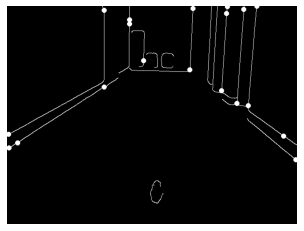

In [84]:
window = edges.copy()

for p in p0 :
    x,y = p.ravel()
    cv2.circle(window, (int(x), int(y)), radius=3, color=(255, 0, 0), thickness=3)

plt.imshow(window, cmap='gray')
plt.axis('off')
plt.show()

In [85]:
import time, traceback 
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None :
            good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        new_p, lines, edges = find_new_points(frame, HOUGH_LINE_THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP, **best_params)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2) 
            good_new = np.vstack((good_new, new_p))  

        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] 

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)
        
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, POINT_DISTANCE_THRESHOLD)
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)

    except Exception as e :
        print(traceback.format_exc())
#         p0 = None
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = get_angle(x1, y1, x2, y2)               
                """only vertical lines"""
                if abs(angle) > 80 and abs(angle) < 100 :  # vertical line 
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    cv2.circle(window, (x1, y1), 5, (0, 255, 0), -1)
                    cv2.circle(window, (x2, y2), 5, (0, 255, 0), -1)
                    
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 1)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
#         print(f"computing time : {time.time() - start : .2f}")
        old_gray = frame_gray.copy()
    
cv2.destroyAllWindows()
cap.release()